In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
nRowsRead = None # specify 'None' if want to read whole file
df1 = pd.read_csv('./NIH-small/sample_labels.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'sample_labels.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 5606 rows and 11 columns


In [3]:
df1.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


### Using datasets package to load data


In [4]:
from datasets import load_dataset, Image
import os

root_dir = './NIH-small/sample/'

dataset = load_dataset('imagefolder', split='train', data_dir=os.path.join(root_dir, 'images'))
# Add a filename column
def add_filename(example):
    example['filename'] = os.path.basename(example['image'].filename)
    return example

dataset = dataset.map(add_filename)

dataset = dataset.cast_column("image", Image(mode="RGB"))

Resolving data files:   0%|          | 0/5606 [00:00<?, ?it/s]

In [5]:
# Load the metadata from the CSV file
import pandas as pd
metadata_file = os.path.join(root_dir, 'sample_labels.csv')
# Load the metadata from the CSV file
metadata_df = pd.read_csv(metadata_file)

# Create a dictionary from the metadata for quick lookup
metadata_dict = metadata_df.set_index('Image Index').to_dict(orient='index')

# Add metadata to the dataset
def add_metadata(example):
    filename = example['filename']
    if filename in metadata_dict:
        metadata = metadata_dict[filename]
        example.update(metadata)
    return example

dataset = dataset.map(add_metadata)


In [6]:
dataset

Dataset({
    features: ['image', 'filename', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y'],
    num_rows: 5606
})

In [7]:
dataset.features

{'image': Image(mode='RGB', decode=True, id=None),
 'filename': Value(dtype='string', id=None),
 'Finding Labels': Value(dtype='string', id=None),
 'Follow-up #': Value(dtype='int64', id=None),
 'Patient ID': Value(dtype='int64', id=None),
 'Patient Age': Value(dtype='string', id=None),
 'Patient Gender': Value(dtype='string', id=None),
 'View Position': Value(dtype='string', id=None),
 'OriginalImageWidth': Value(dtype='int64', id=None),
 'OriginalImageHeight': Value(dtype='int64', id=None),
 'OriginalImagePixelSpacing_x': Value(dtype='float64', id=None),
 'OriginalImagePixelSpacing_y': Value(dtype='float64', id=None)}

In [8]:
from datasets.features import ClassLabel, Sequence

# Split "Finding Labels" into multiple labels
metadata_df['Finding Labels'] = metadata_df['Finding Labels'].str.split('|')

# Get all unique labels
all_labels = set(label for sublist in metadata_df['Finding Labels'] for label in sublist)

# Create a ClassLabel feature for each unique label
class_labels = ClassLabel(names=list(all_labels))

# Define the label feature as a sequence of ClassLabel
labels_type = Sequence(class_labels)



# # Remove unnecessary columns if needed
# dataset = dataset.remove_columns(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender'])



In [9]:
labels_type

Sequence(feature=ClassLabel(names=['Mass', 'Hernia', 'Pneumonia', 'Pneumothorax', 'Pleural_Thickening', 'Edema', 'Nodule', 'Emphysema', 'Cardiomegaly', 'Infiltration', 'No Finding', 'Effusion', 'Fibrosis', 'Atelectasis', 'Consolidation'], id=None), length=-1, id=None)

In [10]:
# Create a dictionary from the metadata for quick lookup
metadata_dict = metadata_df.set_index('Image Index').to_dict(orient='index')

# Add metadata to the dataset, including the sequence of class labels
def add_metadata(example):
    filename = example['filename']
    if filename in metadata_dict:
        metadata = metadata_dict[filename]
        example.update(metadata)
        example['labels'] = [class_labels.str2int(label) for label in metadata['Finding Labels']]
    return example

# Apply the metadata and features to the dataset
dataset = dataset.map(add_metadata)


Map:   0%|          | 0/5606 [00:00<?, ? examples/s]

In [11]:
dataset

Dataset({
    features: ['image', 'filename', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y', 'labels'],
    num_rows: 5606
})

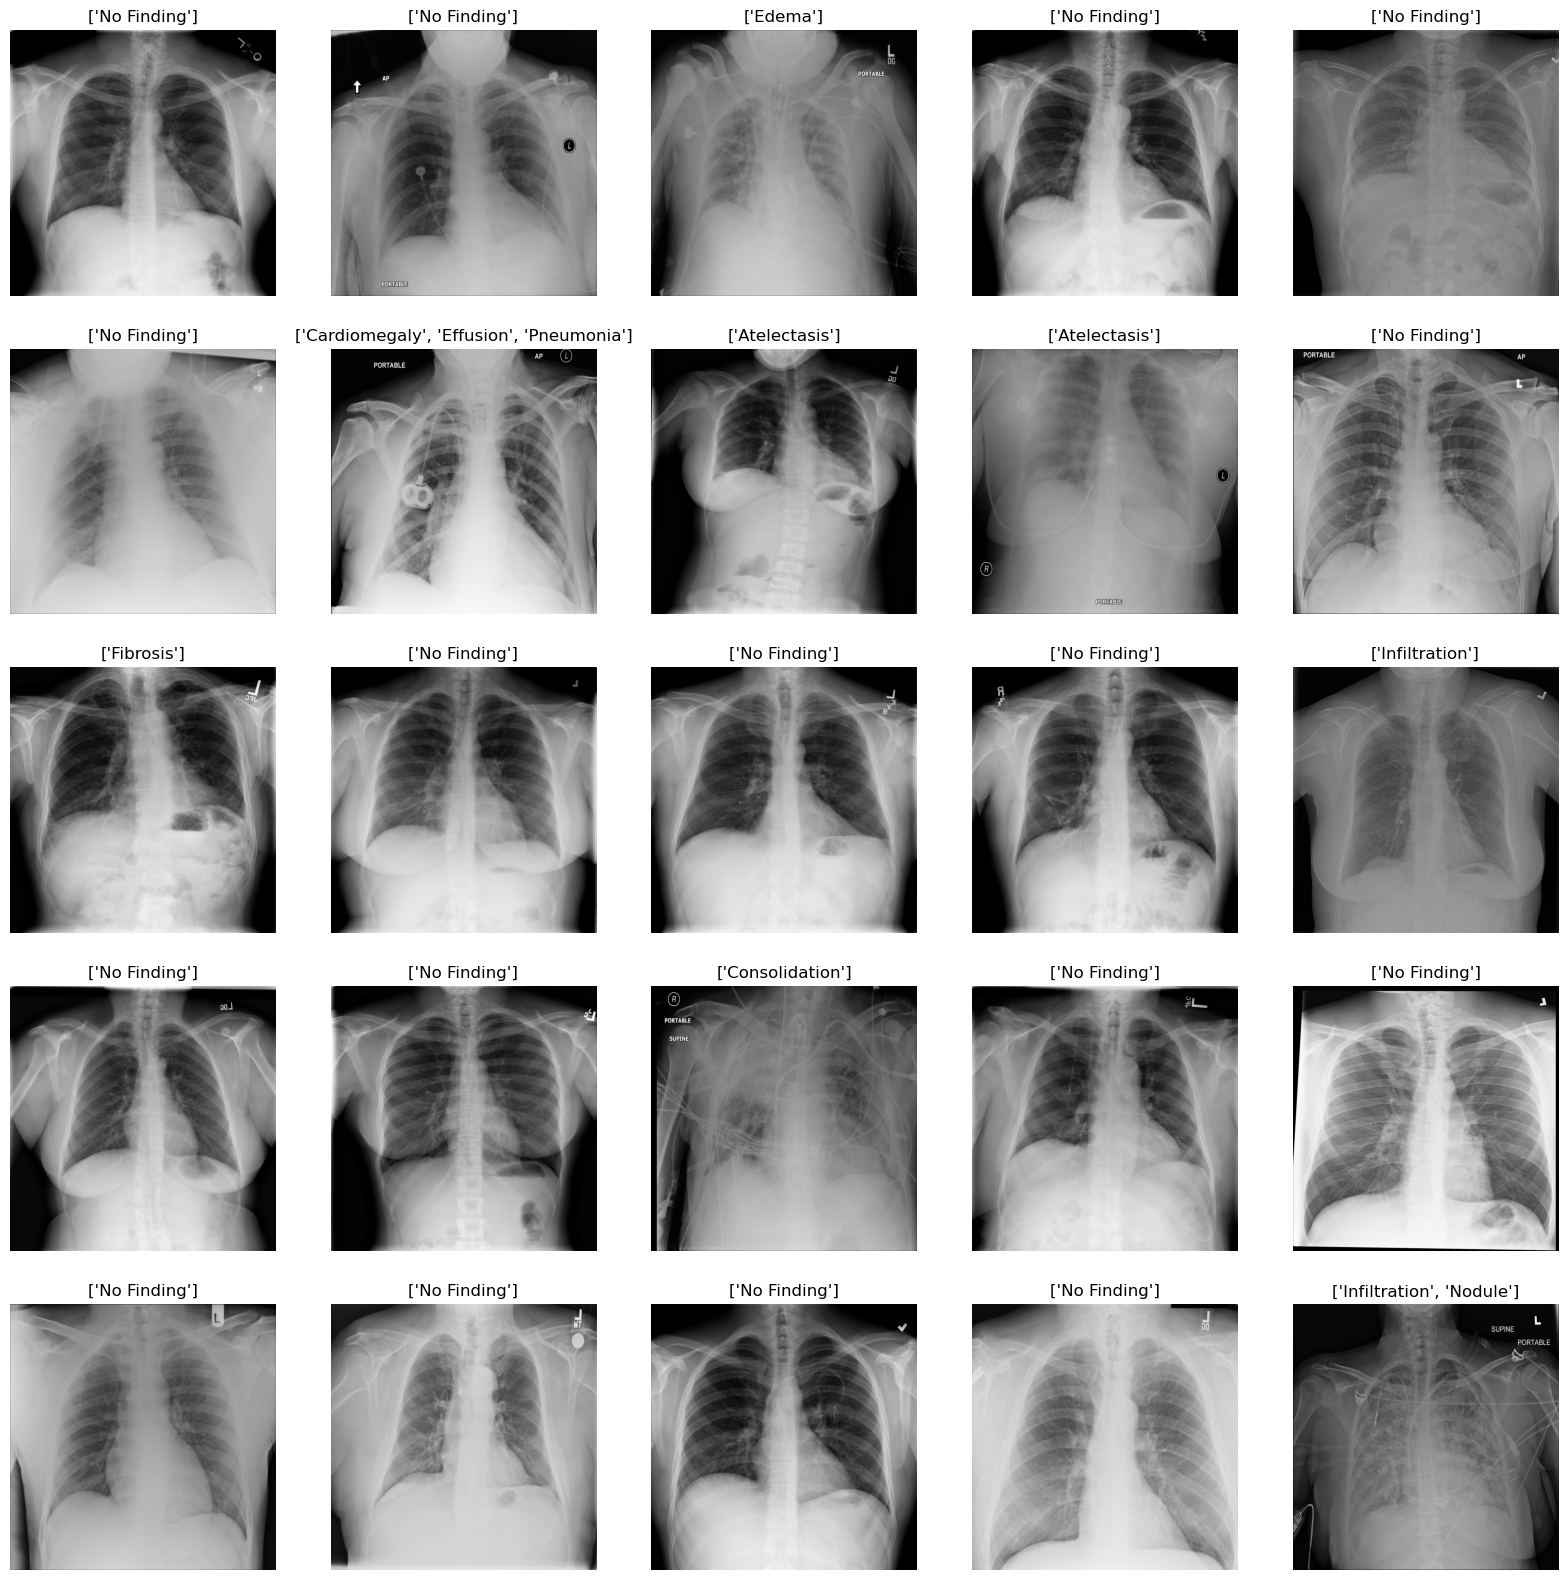

In [13]:
import matplotlib.pyplot as plt
import numpy as np

labels_list = class_labels.names
num_labels = len(labels_list)

def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    id2label = dict(zip(list(range(0, num_labels)), labels_list))
    for i in range(rows*cols):
        img = samples[i]['image']
        # image = samples[i]["pixel_values"]
        labels = samples[i]['Finding Labels']
        fig.add_subplot(rows,cols,i+1)
        # plt.imshow(image[0])
        plt.imshow(img)
        plt.title(labels)
        plt.axis('off')
            
show_samples(dataset,rows=5,cols=5)

In [23]:
dataset[0]['filename'], dataset[0]['labels']

('00000013_005.png', [6, 13, 7, 3])

In [28]:
dataset.features

{'image': Image(mode='RGB', decode=True, id=None),
 'filename': Value(dtype='string', id=None),
 'Finding Labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Follow-up #': Value(dtype='int64', id=None),
 'Patient ID': Value(dtype='int64', id=None),
 'Patient Age': Value(dtype='string', id=None),
 'Patient Gender': Value(dtype='string', id=None),
 'View Position': Value(dtype='string', id=None),
 'OriginalImageWidth': Value(dtype='int64', id=None),
 'OriginalImageHeight': Value(dtype='int64', id=None),
 'OriginalImagePixelSpacing_x': Value(dtype='float64', id=None),
 'OriginalImagePixelSpacing_y': Value(dtype='float64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [15]:
metadata_df['Finding Labels'].value_counts()[:15]

Finding Labels
[No Finding]                   3044
[Infiltration]                  503
[Effusion]                      203
[Atelectasis]                   192
[Nodule]                        144
[Pneumothorax]                  114
[Mass]                           99
[Consolidation]                  72
[Effusion, Infiltration]         69
[Pleural_Thickening]             65
[Atelectasis, Infiltration]      57
[Atelectasis, Effusion]          55
[Cardiomegaly]                   50
[Infiltration, Nodule]           44
[Emphysema]                      42
Name: count, dtype: int64